In [1]:
import warnings

import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy as sp

from scipy.special import expit as logistic

%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

In [2]:
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 12.1

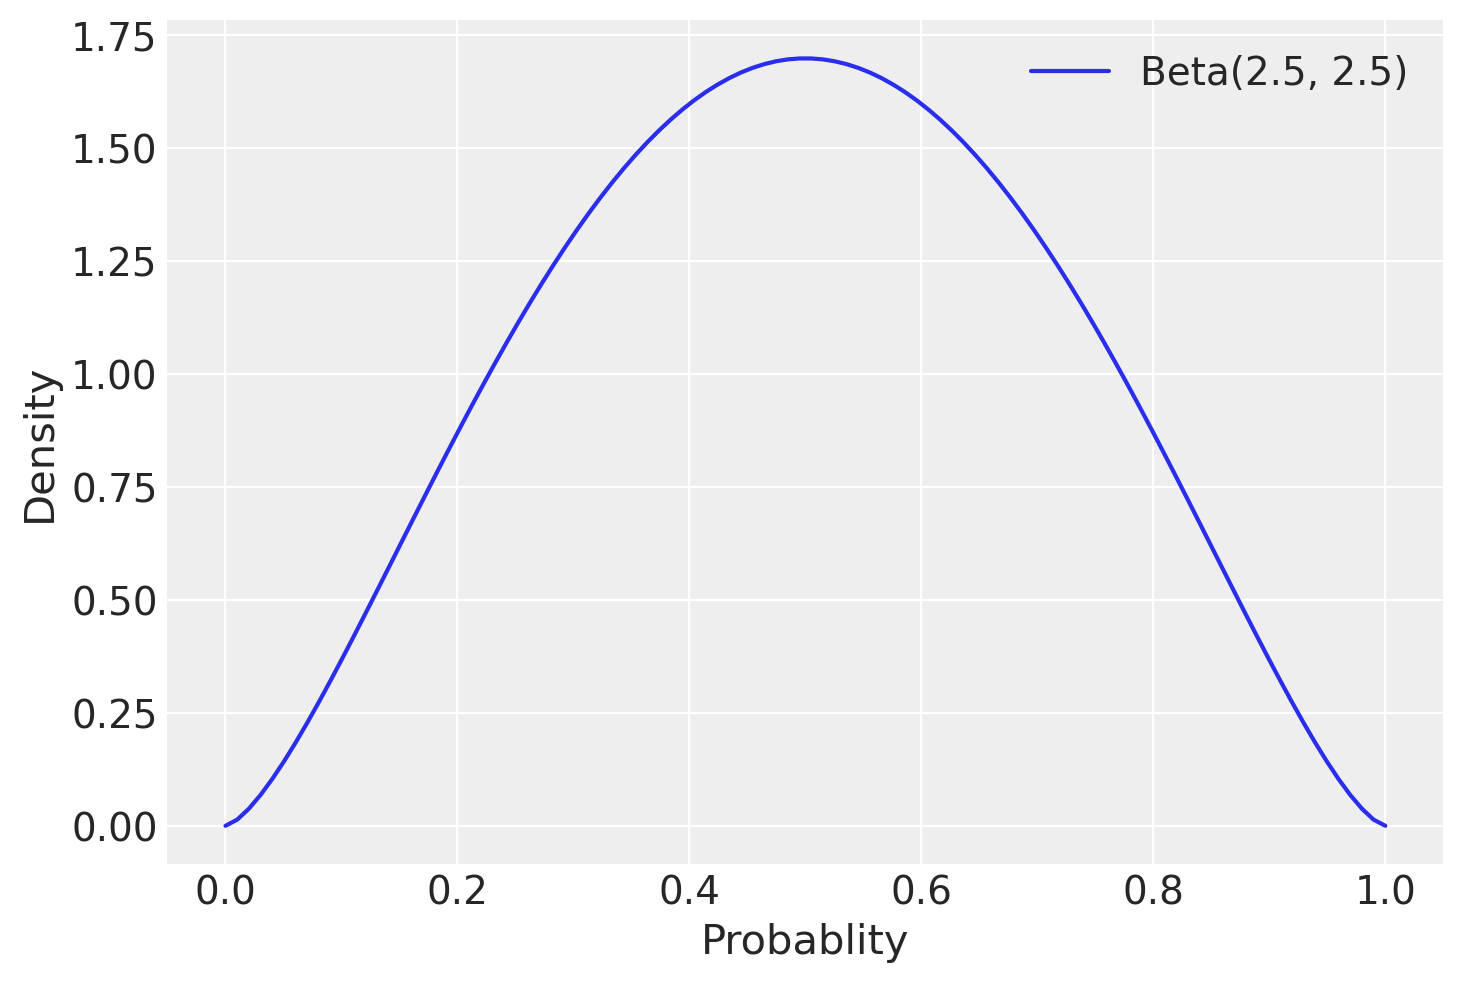

In [3]:
x_plot = np.linspace(0, 1, 100)
pbar = 0.5
theta = 5.0
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot[:, np.newaxis], pbar * theta, (1 - pbar) * theta),
    label=f"Beta({pbar * theta}, {(1 - pbar) * theta})",
)
plt.xlabel("Probablity")
plt.ylabel("Density")
plt.legend();

#### Code 12.2

In [4]:
admit_df = pd.read_csv("Data/UCBadmit.csv", sep=";")
N = admit_df.applications.values
gid = (admit_df["applicant.gender"] == "female").astype(int).values
admit_df.head()

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325


In [5]:
with pm.Model() as m12_1:
    a = pm.Normal("a", 0.0, 1.5, shape=2)
    phi = pm.Exponential("phi", 1.0)

    theta = pm.Deterministic("theta", phi + 2.0)
    pbar = pm.Deterministic("pbar", pm.math.invlogit(a[gid]))

    A = pm.BetaBinomial("A", pbar * theta, (1.0 - pbar) * theta, N, observed=admit_df.admit.values)

    idata_12_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


#### Code 12.3

In [6]:
az.summary(idata_12_1, var_names=["a", "phi", "theta"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.44,0.44,-1.10,0.29,0.01,0.01,2976.25,2274.33,1.0
a[1],-0.33,0.41,-1.01,0.26,0.01,0.01,2701.50,2539.75,1.0
phi,1.04,0.81,0.00,2.06,0.01,0.01,2376.88,1594.05,1.0
theta,3.04,0.81,2.00,4.06,0.01,0.01,2376.88,1594.05,1.0


In [7]:
post_a = az.extract_dataset(idata_12_1["posterior"])["a"]
diff_a = post_a[0, :] - post_a[1, :]
az.summary({"diff_a": diff_a}, kind="stats", round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_a,-0.11,0.58,-1.02,0.84


#### Code 12.4

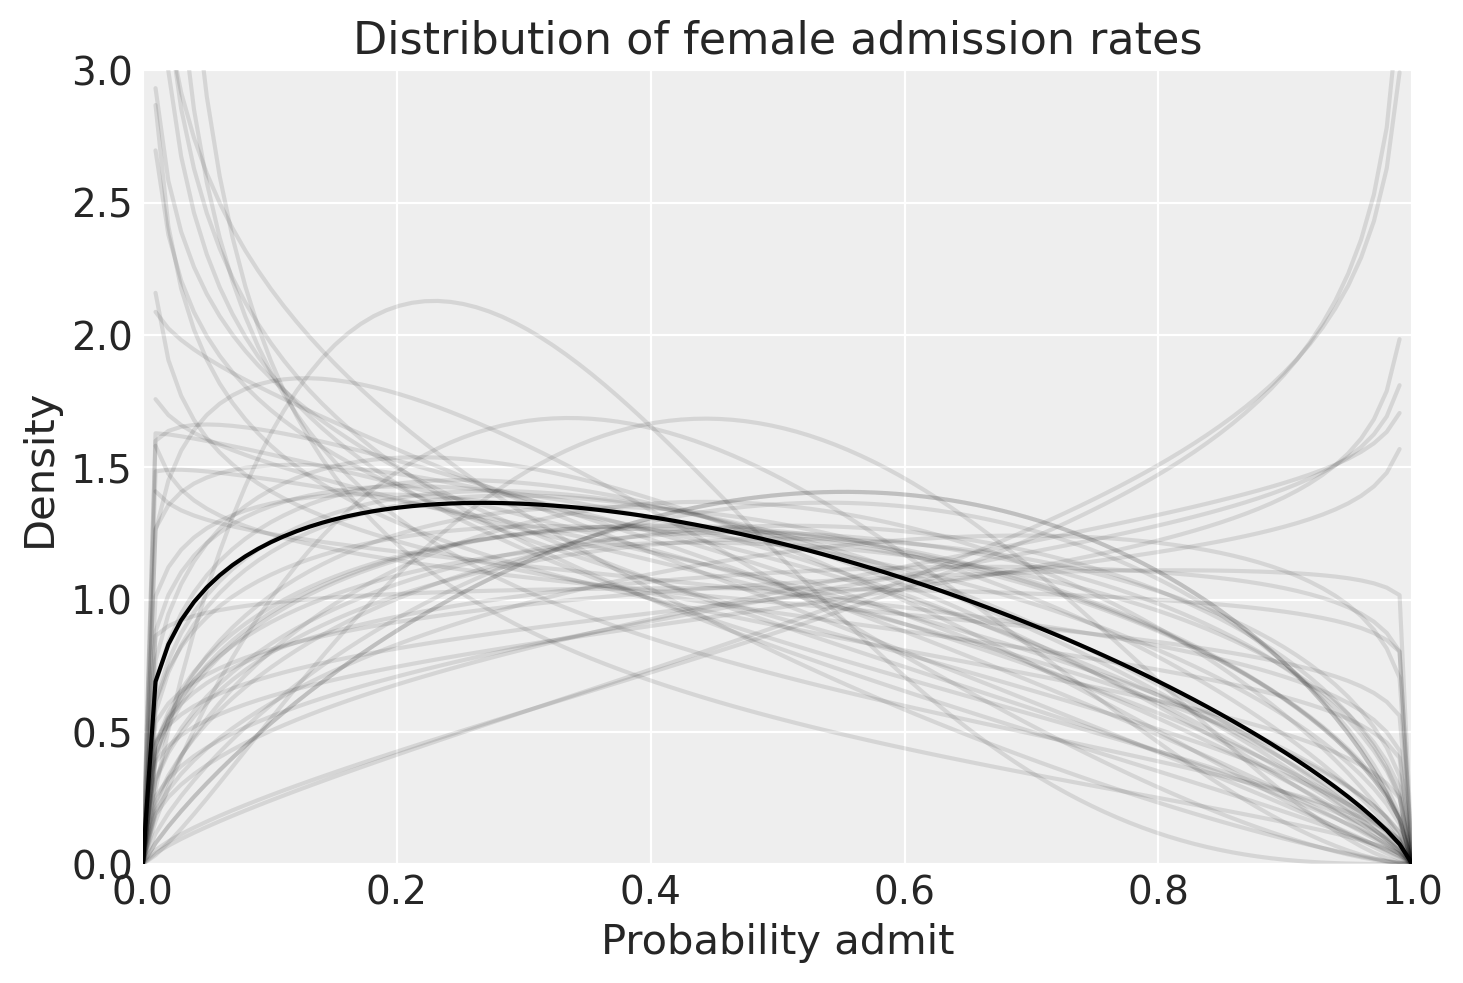

In [8]:
gid = 1
x_plot = np.linspace(0, 1, 100)
post_theta = az.extract_dataset(idata_12_1["posterior"])["theta"]

# draw posterior mean beta distribution:
pbar_mean = logistic(post_a[gid, :]).mean()
theta_mean = post_theta.mean()
plt.plot(
    x_plot,
    sp.stats.beta.pdf(x_plot, pbar_mean * theta_mean, (1.0 - pbar_mean) * theta_mean),
    c="k",
)

# draw 50 beta distributions sampled from posterior:
plt.plot(
    x_plot,
    sp.stats.beta.pdf(
        x_plot[:, np.newaxis],
        logistic(post_a[gid, :])[:50] * post_theta[:50],
        (1.0 - logistic(post_a[gid, :])[:50]) * post_theta[:50],
    ),
    c="k",
    alpha=0.1,
)

plt.xlim(0.0, 1.0)
plt.xlabel("Probability admit")
plt.ylim(0.0, 3.0)
plt.ylabel("Density")
plt.title("Distribution of female admission rates");

#### Code 12.5

In [9]:
with m12_1:
    ppc = pm.sample_posterior_predictive(idata_12_1, random_seed=RANDOM_SEED)[
        "posterior_predictive"
    ]["A"]
pp_admit = ppc / N

Sampling: [A]


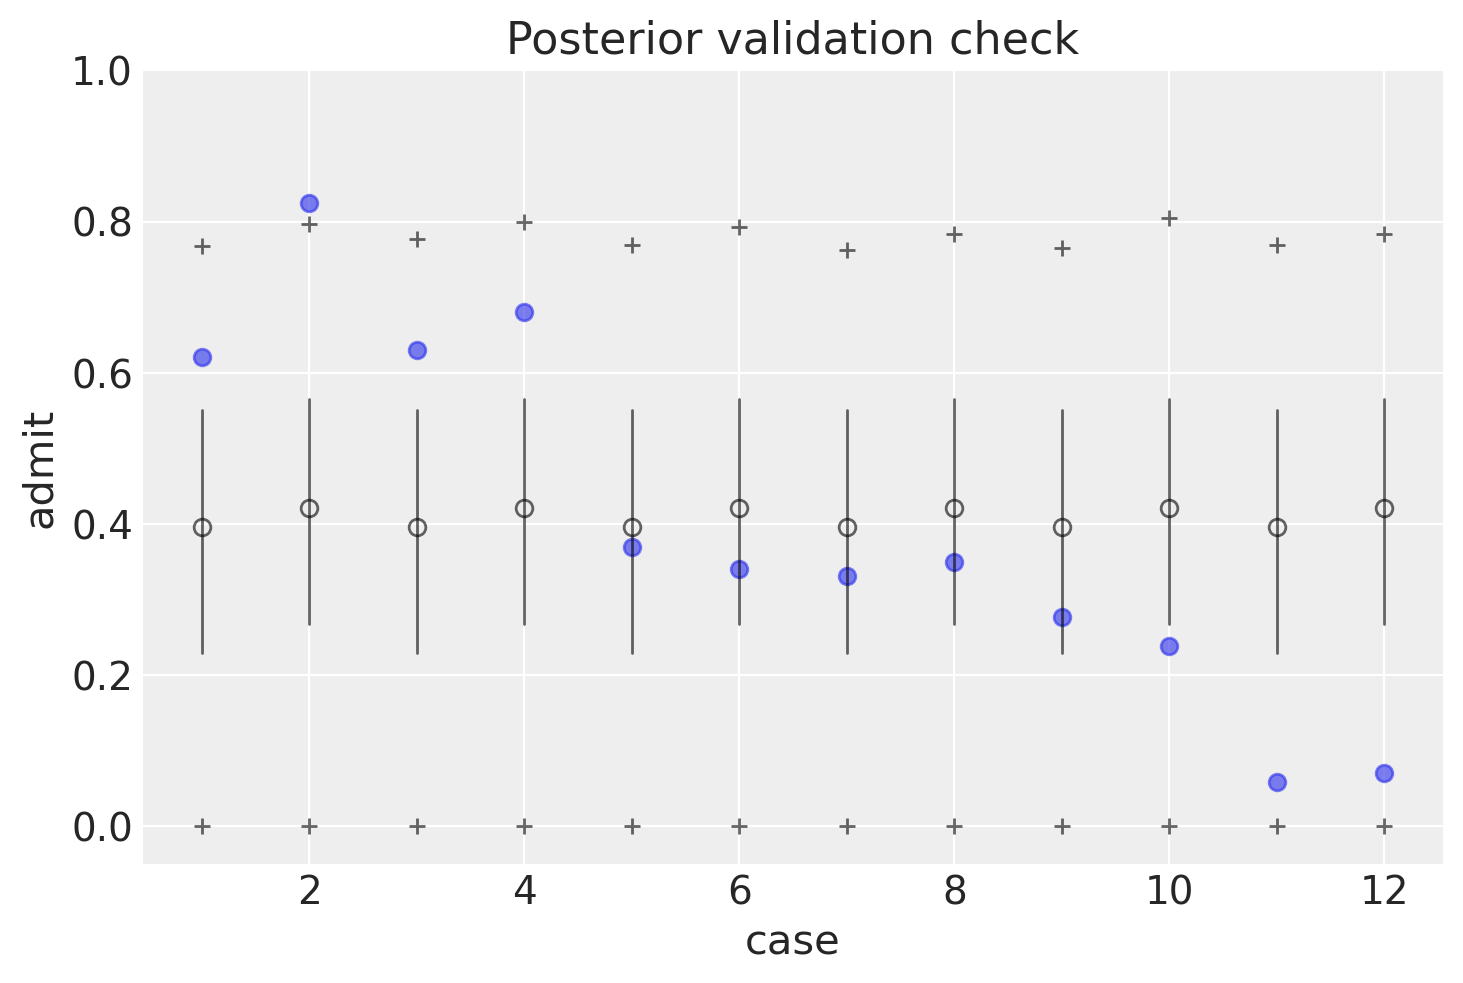

In [10]:
plt.plot(range(1, 13), admit_df.admit / N, "C0o", ms=6, alpha=0.6)
plt.plot(
    range(1, 13),
    idata_12_1["posterior"]["pbar"].mean(["chain", "draw"]),
    "ko",
    fillstyle="none",
    ms=6,
    alpha=0.6,
)
plt.plot(
    [range(1, 13), range(1, 13)],
    az.hdi(idata_12_1["posterior"]["pbar"])["pbar"].T,
    "k-",
    lw=1,
    alpha=0.6,
)
plt.plot([range(1, 13), range(1, 13)], az.hdi(pp_admit)["A"].T, "k+", ms=6, alpha=0.6)

plt.xlabel("case")
plt.ylabel("admit")
plt.title("Posterior validation check")
plt.ylim(-0.05, 1);

#### Code 12.6

c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\pymc\data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g, phi]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 47 seconds.


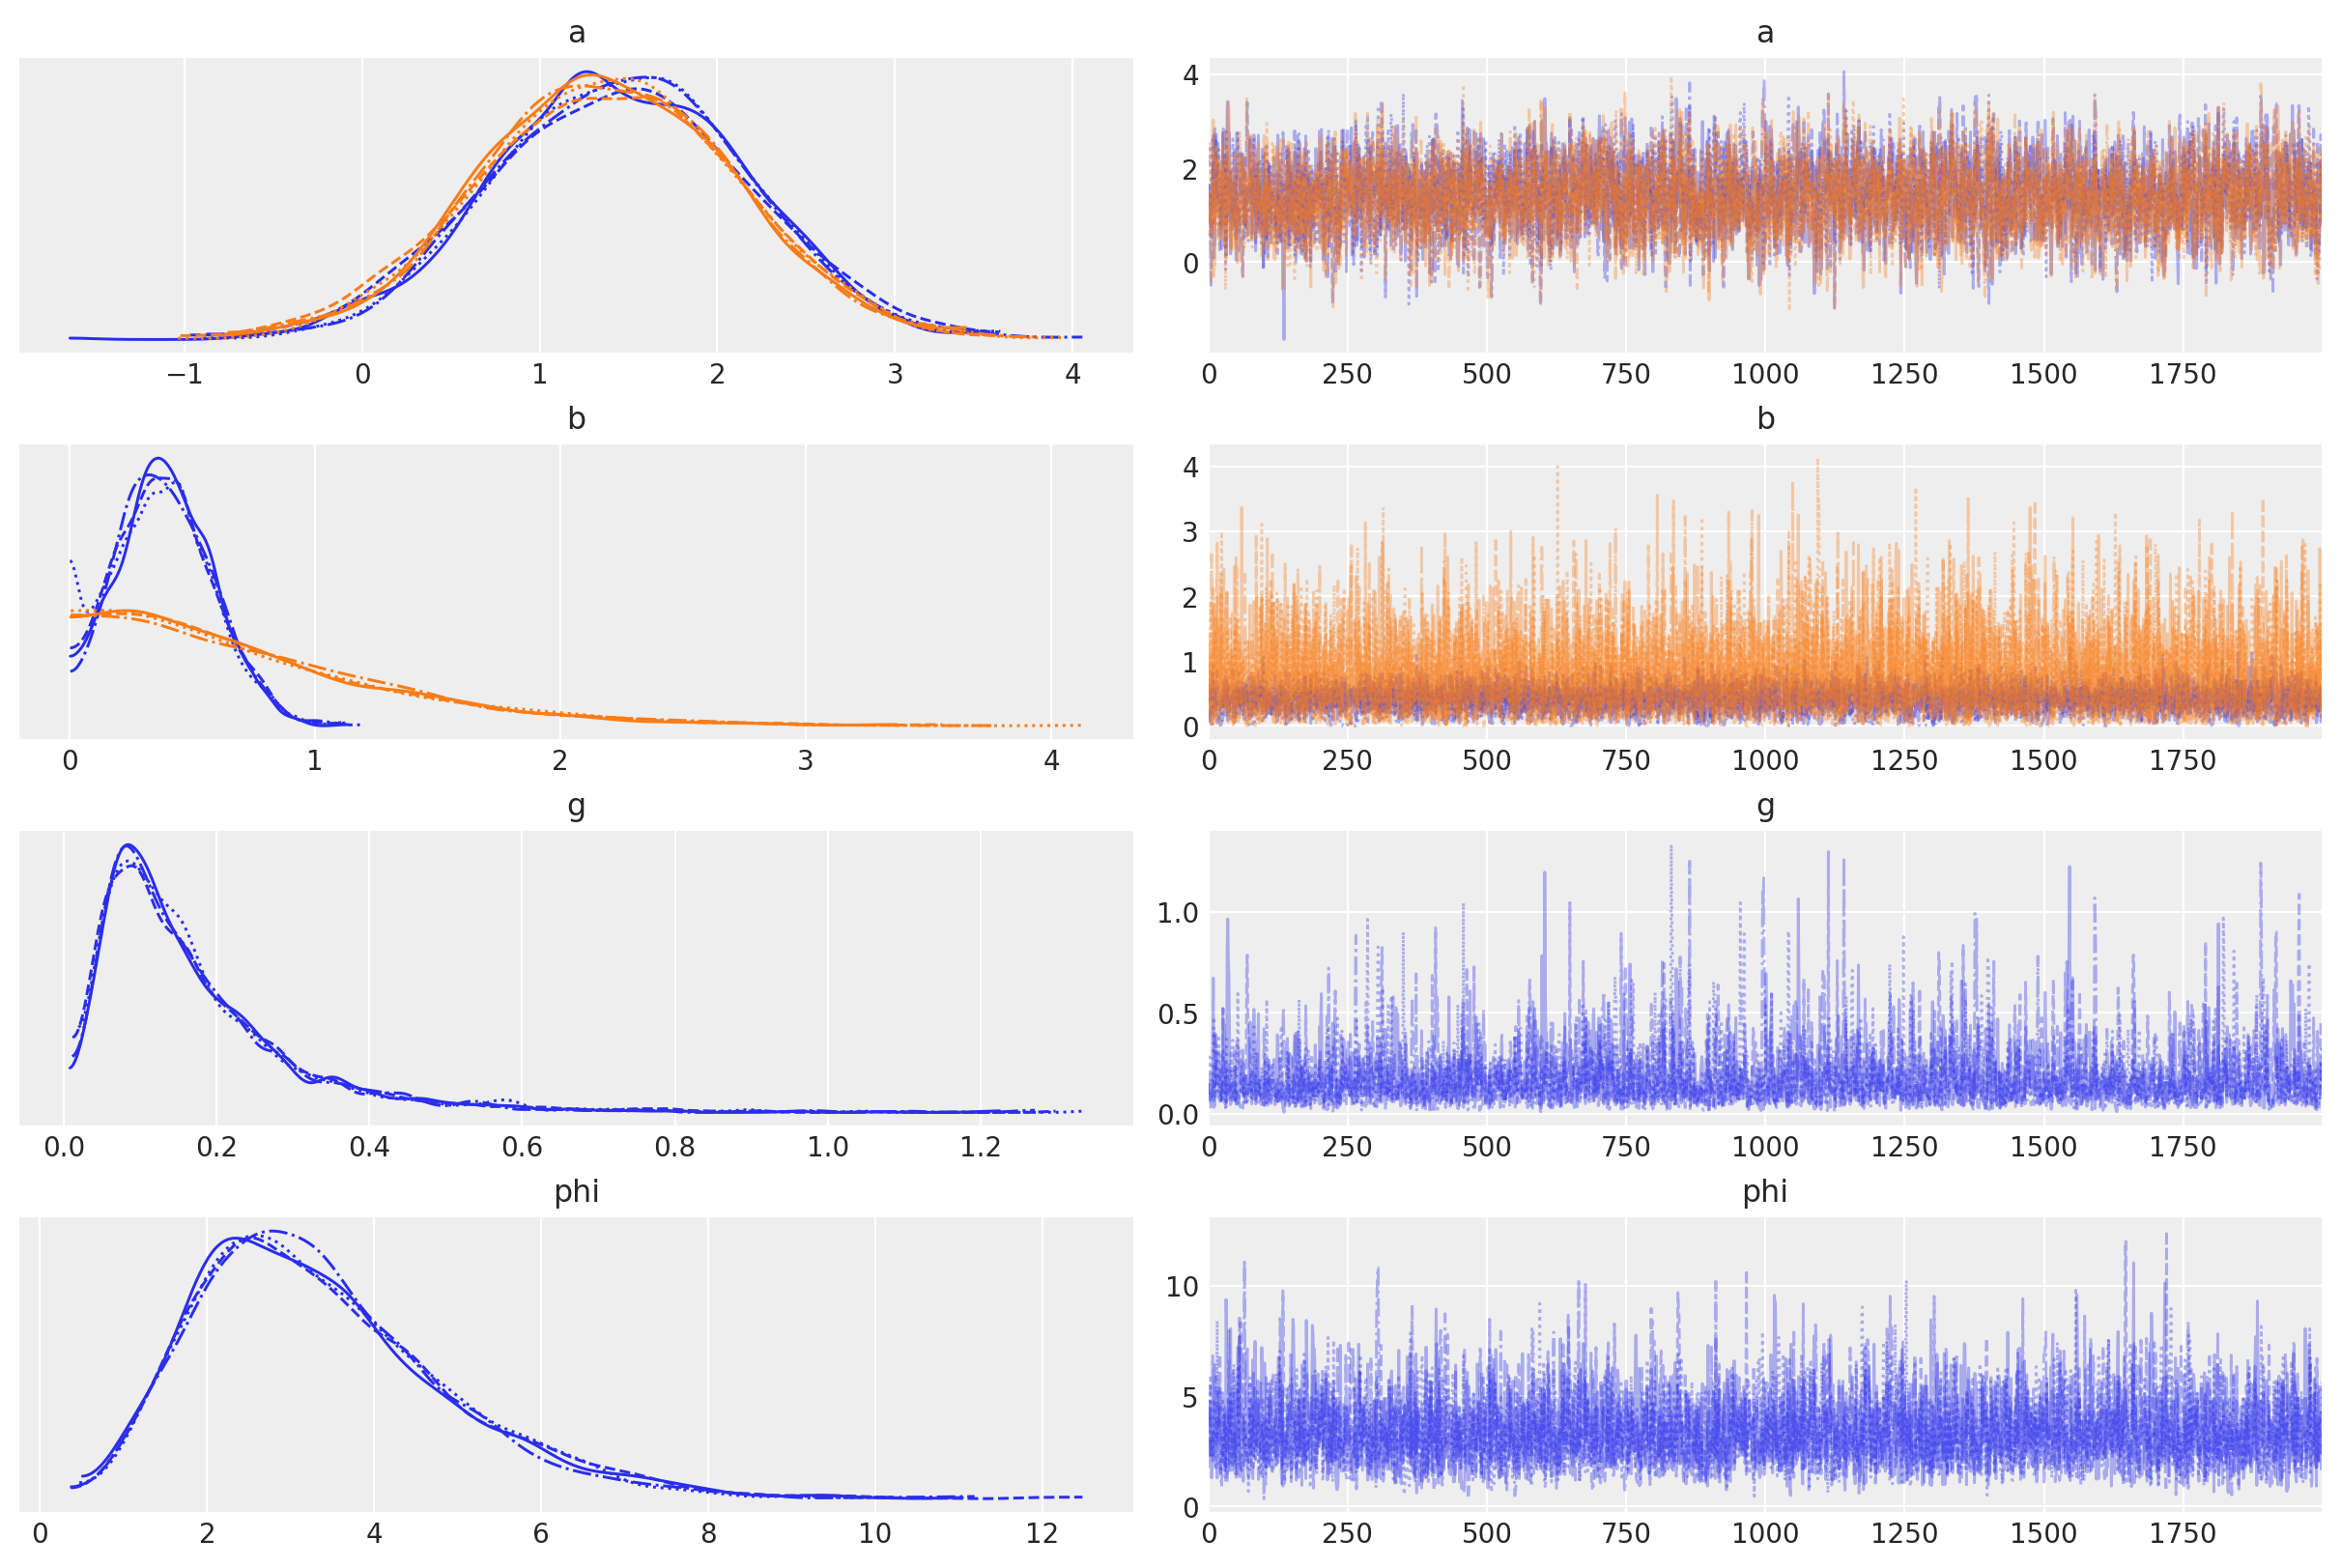

In [11]:
dk = pd.read_csv("Data/Kline", sep=";")
P = standardize(np.log(dk.population)).values
P = P + np.abs(P.min()) + 0.1  # must be > 0 (see chp. 11)
c_id = (dk.contact == "high").astype(int).values

with pm.Model() as m12_2:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)
    phi = pm.Exponential("phi", 1.0)

    cid = pm.intX(pm.MutableData("cid", c_id))
    P_ = pm.Data("P", P)
    lam = (pt.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.NegativeBinomial("total_tools", lam, phi, observed=dk.total_tools.values)

    idata_12_2 = pm.sample(
        2000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

# store pareto-k values for plot:
k_12 = az.loo(idata_12_2, pointwise=True).pareto_k.values

az.plot_trace(idata_12_2, compact=True);

#### Bonus: Figure 12.2

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, g]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 107 seconds.
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


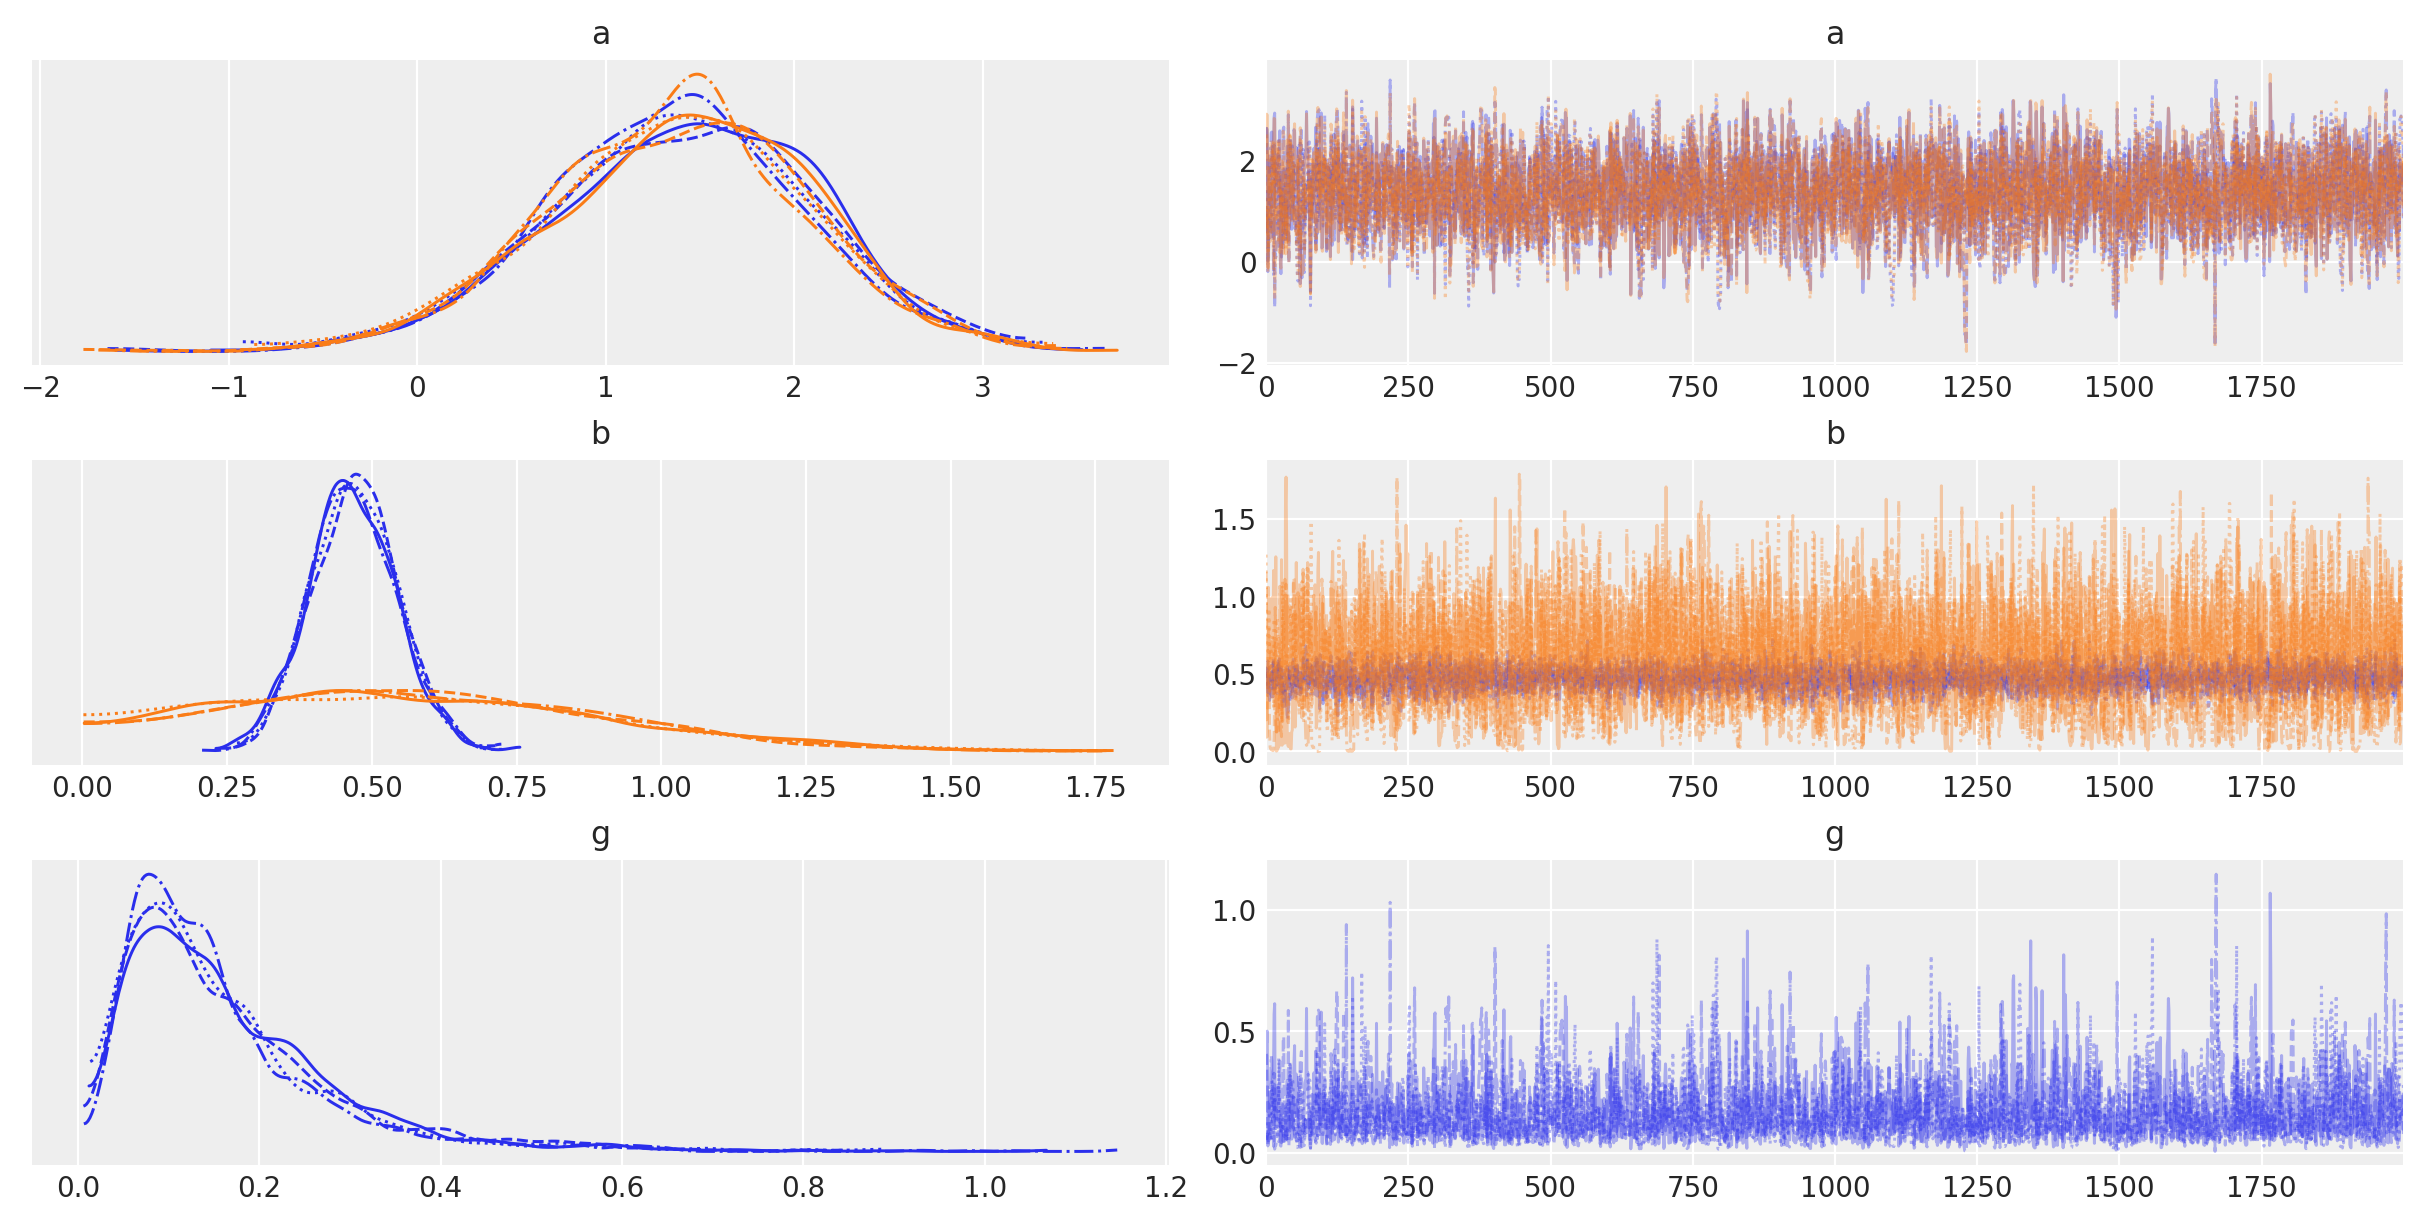

In [14]:
with pm.Model() as m_11_11:
    a = pm.Normal("a", 1.0, 1.0, shape=2)
    b = pm.Exponential("b", 1.0, shape=2)
    g = pm.Exponential("g", 1.0)

    cid = pm.intX(pm.MutableData("cid", c_id))
    P_ = pm.MutableData("P", P)
    lam = (pt.exp(a[cid]) * P_ ** b[cid]) / g

    T = pm.Poisson("total_tools", lam, observed=dk.total_tools.values)

    idata_11_11 = pm.sample(
        2000,
        tune=2000,
        target_accept=0.9,
        random_seed=RANDOM_SEED,
        idata_kwargs={"log_likelihood": True},
    )

# store pareto-k values for plot:
k_11 = az.loo(idata_11_11, pointwise=True).pareto_k.values

az.plot_trace(idata_11_11, compact=True);

In [15]:
ns = 100
P_seq = np.linspace(-1.4, 3.0, ns) + 1.4  # our little trick

with m_11_11:
    # predictions for cid=0 (low contact)
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0_11 = pm.sample_posterior_predictive(idata_11_11, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    # predictions for cid=1 (high contact)
    pm.set_data({"cid": np.array([1] * ns)})
    lam1_11 = pm.sample_posterior_predictive(idata_11_11, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

with m12_2:
    pm.set_data({"cid": np.array([0] * ns), "P": P_seq})
    lam0_12 = pm.sample_posterior_predictive(idata_12_2, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

    pm.set_data({"cid": np.array([1] * ns)})
    lam1_12 = pm.sample_posterior_predictive(idata_12_2, var_names=["total_tools"])[
        "posterior_predictive"
    ]["total_tools"]

lmu0_11, lmu1_11 = lam0_11.mean(["chain", "draw"]), lam1_11.mean(["chain", "draw"])
lmu0_12, lmu1_12 = lam0_12.mean(["chain", "draw"]), lam1_12.mean(["chain", "draw"])

Sampling: [total_tools]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (100,).
Apply node that caused the error: poisson_rv{0, (0,), int64, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0x25C73CC2500>), [10], 4, Composite{((exp(i2) * (i0 ** i1)) / i3)}.0)
Toposort index: 4
Inputs types: [RandomGeneratorType, TensorType(int64, shape=(1,)), TensorType(int64, shape=()), TensorType(float64, shape=(None,))]
Inputs shapes: ['No shapes', (1,), (), (100,)]
Inputs strides: ['No strides', (8,), (), (8,)]
Inputs values: [Generator(PCG64) at 0x25C73CC2500, array([10], dtype=int64), array(4, dtype=int64), 'not shown']
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
# scale point size to Pareto-k:
k_11 /= k_11.max()
psize_11 = 250 * k_11
k_12 /= k_12.max()
psize_12 = 250 * k_12

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 6))

# Poisson predictions:
# unstandardize our log pop sequence:
P_seq = np.exp(
    (P_seq - 1.4) * np.log(dk.population.values).std() + np.log(dk.population.values).mean()
)
az.plot_hdi(P_seq, lam1_11, color="b", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu1_11, color="b", alpha=0.7, label="high contact mean")

az.plot_hdi(P_seq, lam0_11, color="k", fill_kwargs={"alpha": 0.2}, ax=ax0)
ax0.plot(P_seq, lmu0_11, "--", color="k", alpha=0.7, label="low contact mean")

# display observed data:
index = c_id == 1
ax0.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_11[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
    label="low contact",
)
ax0.scatter(
    dk.population[index], dk.total_tools[index], s=psize_11[index], alpha=0.8, label="high contact"
)
plt.setp(ax0.get_xticklabels(), ha="right", rotation=45)
ax0.set_xlim((-10_000, 300_000))
ax0.set_xlabel("population")
ax0.set_ylabel("total tools")
ax0.set_ylim((-5, 125))
ax0.set_title("Pure Poisson model")
ax0.legend(fontsize=8, ncol=2)

# Gamma-Poisson predictions:
az.plot_hdi(P_seq, lam1_12, color="b", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu1_12, color="b", alpha=0.7)

az.plot_hdi(P_seq, lam0_12, color="k", fill_kwargs={"alpha": 0.2}, ax=ax1)
ax1.plot(P_seq, lmu0_12, "--", color="k", alpha=0.7)

# display observed data:
ax1.scatter(
    dk.population[~index],
    dk.total_tools[~index],
    s=psize_12[~index],
    facecolors="none",
    edgecolors="k",
    alpha=0.8,
    lw=1,
)
ax1.scatter(dk.population[index], dk.total_tools[index], s=psize_12[index], alpha=0.8)
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45)
ax1.set_xlim((-10_000, 300_000))
ax1.set_xlabel("population")
ax1.set_ylim((-5, 125))
ax1.set_ylabel("total tools")
ax1.set_title("Gamma-Poisson model")

#### Code 12.7

In [ ]:
# define parameters
PROB_DRINK = 0.2  # 20% of days
RATE_WORK = 1.0  # average 1 manuscript per day

# sample one year of production
N = 365

# simulate days monks drink
drink = np.random.binomial(1, PROB_DRINK, size=N)

# simulate manuscripts completed
y = (1 - drink) * np.random.poisson(RATE_WORK, size=N)

#### Code 12.8

In [ ]:
zeros_drink = drink.sum()
zeros_work = (y == 0).sum() - zeros_drink

bins = np.arange(y.max() + 1) - 0.5
plt.hist(y, bins=bins, align="mid", rwidth=0.2, color="k", alpha=0.5)
plt.bar(0.0, zeros_drink, bottom=zeros_work, width=0.2, color="b", alpha=0.7)

plt.xticks(bins + 0.5)
plt.xlabel("manuscripts completed")
plt.ylabel("Frequency");

#### Code 12.9

In [ ]:
with pm.Model() as m12_3:
    ap = pm.Normal("ap", -1.5, 1.0)
    al = pm.Normal("al", 1.0, 0.5)

    p = pm.math.invlogit(ap)
    lambda_ = pm.math.exp(al)

    y_obs = pm.ZeroInflatedPoisson("y_obs", 1.0 - p, lambda_, observed=y)

    idata_12_3 = pm.sample(tune=2000, random_seed=RANDOM_SEED)
az.summary(idata_12_3, round_to=2)

#### Code 12.10

In [ ]:
logistic(idata_12_3["posterior"]["ap"]).mean(["chain", "draw"])  # probability drink

In [ ]:
np.exp(idata_12_3["posterior"]["al"]).mean(
    ["chain", "draw"]
)  # rate finish manuscripts, when not drinking

#### Code 12.11

Stan-related

#### Code 12.12

In [ ]:
trolley_df = pd.read_csv("Data/Trolley.csv", sep=";")
trolley_df.head()

#### Code 12.13

In [ ]:
ax = trolley_df.response.sort_values().value_counts(sort=False).plot(kind="bar", alpha=0.8)
ax.set_xlabel("response")
ax.set_ylabel("Frequency");

#### Code 12.14

In [ ]:
ax = (
    trolley_df.response.sort_values()
    .value_counts(normalize=True, sort=False)
    .cumsum()
    .plot(marker="o")
)

ax.set_xlim(0.9, 7.1)
ax.set_xlabel("response", fontsize=14)
ax.set_ylabel("cumulative proportion");

#### Code 12.15

In [ ]:
lco = (
    trolley_df.response.sort_values()
    .value_counts(normalize=True, sort=False)
    .cumsum()
    .apply(sp.special.logit)
)
lco.round(2)

In [ ]:
ax = lco.plot(marker="o")
ax.set_xlim(0.9, 7)
ax.set_xlabel("response")
ax.set_ylabel("log-cumulative-odds");

#### Code 12.16 / 17

In [ ]:
with pm.Model() as m12_4:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    R = pm.OrderedLogistic("R", 0.0, cutpoints, observed=trolley_df.response.values - 1)

#### Code 12.18

In [ ]:
with m12_4:
    idata_12_4 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_12_4, round_to=2)

#### Code 12.19

In [ ]:
logistic(idata_12_4["posterior"]["cutpoints"]).mean(["chain", "draw"]).round(3)

#### Code 12.20

In [ ]:
def ordered_logistic_proba(a):
    p_cum = logistic(a)
    p_cum = np.concatenate(([0.0], p_cum, [1.0]))

    return p_cum[1:] - p_cum[:-1]


pk = ordered_logistic_proba(idata_12_4["posterior"]["cutpoints"].mean(["chain", "draw"]))
pk.round(2)

#### Code 12.21

In [ ]:
(pk * np.arange(1, 8)).sum()

#### Code 12.22

In [ ]:
pk = ordered_logistic_proba(idata_12_4["posterior"]["cutpoints"].mean(["chain", "draw"]) - 0.5)
pk.round(2)

#### Code 12.23

In [ ]:
(pk * np.arange(1, 8)).sum()

#### Code 12.24

In [ ]:
R = trolley_df.response.values - 1

with pm.Model() as m12_5:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)

    A = pm.Data("A", trolley_df.action.values)
    I = pm.Data("I", trolley_df.intention.values)
    C = pm.Data("C", trolley_df.contact.values)

    BI = bI + bIA * A + bIC * C
    phi = pm.Deterministic("phi", bA * A + bC * C + BI * I)

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    idata_12_5 = pm.sample(random_seed=RANDOM_SEED)

az.summary(idata_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], round_to=2)

#### Code 12.25

In [ ]:
az.plot_forest(
    idata_12_5, var_names=["bIC", "bIA", "bC", "bI", "bA"], figsize=(5, 2), combined=True
);

#### Code 12.26 - 28

In [ ]:
# Observed cum probs:
p_obs = (
    trolley_df.groupby(["action", "contact", "intention"])
    .response.value_counts(normalize=True, sort=False)
    .unstack()
    .cumsum(axis=1)
    .iloc[:, :-1]
)
p_obs.columns = range(6)
p_obs

In [ ]:
# Counterfactual cases:
cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]),
    columns=["action", "contact", "intention"],
)
cases_df

In [ ]:
with m12_5:
    pm.set_data(
        {
            "A": cases_df.action.values,
            "C": cases_df.contact.values,
            "I": cases_df.intention.values,
        }
    )
    pp_phi = pm.sample_posterior_predictive(idata_12_5, var_names=["phi"], random_seed=RANDOM_SEED)[
        "posterior_predictive"
    ]

In [ ]:
def p_ord_logit(responses: range, phi: np.ndarray, a: np.ndarray):
    """
    For the given posterior sample, computes the cumulative probabilities
    of each response in each of the counterfactual values of the predictors.

    responses: range of possible responses in the experiment
    phi: posterior phi for each counterfactual case
    a: posterior intercept for each response
    """
    p = pd.DataFrame(index=range(len(cases_df)), columns=responses)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])

    p = pd.concat([cases_df, p], axis=1).set_index(["action", "contact", "intention"]).sort_index()
    p.index.name = "case"
    p.columns.name = "response"

    return p

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

pp_cut_array = np.array(az.extract_dataset(idata_12_5["posterior"])["cutpoints"]).T
pp_phi_array = np.array(az.extract_dataset(pp_phi)["phi"]).T

for s in range(50):
    p = p_ord_logit(responses=range(6), phi=pp_phi_array[s], a=pp_cut_array[s])

    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0, 1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)

        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")

        cur_ax += 1

#### Code 12.29

In [ ]:
with m12_5:
    pp_resp = pm.sample_posterior_predictive(
        idata_12_5, var_names=["resp_obs"], random_seed=RANDOM_SEED
    )["posterior_predictive"]
    pp_resp_array = np.array(az.extract_dataset(pp_resp)["resp_obs"])

resp_df = pd.DataFrame(pp_resp_array)
resp_df.index.name = "case"
resp_df = (
    pd.concat([cases_df, resp_df], axis=1)
    .set_index(["action", "contact", "intention"])
    .sort_index()
)
resp_df

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
bins, xticks, xlabels, colors = (
    np.arange(8) - 0.5,
    np.arange(7),
    np.arange(1, 8),
    ["k", "b"],
)

axes[0].hist(
    [resp_df.loc[0, 0, 0], resp_df.loc[0, 0, 1]],
    bins=bins,
    rwidth=0.5,
    label=["intention=0", "intention=1"],
    color=colors,
    alpha=0.7,
)
axes[0].set_title("action=0, contact=0")
axes[0].set_ylabel("frequency")
axes[0].legend(fontsize=10)

axes[1].hist(
    [resp_df.loc[1, 0, 0], resp_df.loc[1, 0, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[1].set_title("action=1, contact=0")

axes[2].hist(
    [resp_df.loc[0, 1, 0], resp_df.loc[0, 1, 1]],
    bins=bins,
    rwidth=0.5,
    color=colors,
    alpha=0.7,
)
axes[2].set_title("action=0, contact=1")

for ax in axes:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)
    ax.set_xlabel("response")

#### Code 12.30

In [ ]:
pd.Categorical(trolley_df.edu)

#### Code 12.31

In [ ]:
trolley_df["edu_new"] = pd.Categorical(
    trolley_df.edu.values,
    categories=[
        "Elementary School",
        "Middle School",
        "Some High School",
        "High School Graduate",
        "Some College",
        "Bachelor's Degree",
        "Master's Degree",
        "Graduate Degree",
    ],
    ordered=True,
)
trolley_df["edu_new"] = trolley_df.edu_new.cat.codes

#### Code 12.32

In [ ]:
delta = np.random.dirichlet(np.repeat(2.0, 7), size=10)

#### Code 12.33

In [ ]:
plt.plot(np.stack([range(1, 8)] * 9).T, delta[1:].T, "-ok", alpha=0.4, fillstyle="none")
plt.plot(np.arange(1, 8).T, delta[0].T, "-ok", lw=3, ms=6)
plt.xlabel("index")
plt.ylabel("probability");

#### Code 12.34

In [ ]:
R = trolley_df.response.values - 1
A = trolley_df.action.values
I = trolley_df.intention.values
C = trolley_df.contact.values
E = trolley_df.edu_new.values

with pm.Model() as m12_6:
    kappa = pm.Normal(
        "kappa",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6),
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    delta = pm.Dirichlet("delta", np.repeat(2.0, 7), shape=7)
    delta_j = pt.concatenate([pt.zeros(1), delta])
    delta_j_cumulative = pt.cumsum(delta_j)

    phi = bE * delta_j_cumulative[E] + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, kappa, observed=R)

    idata_12_6 = pm.sample(2000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED)

#### Code 12.35

In [ ]:
az.summary(idata_12_6, var_names=["bA", "bC", "bI", "bE", "delta"], round_to=2)

#### Code 12.36

In [ ]:
idata_12_6.posterior.coords["delta_dim_0"] = [
    "MidSch",
    "SHS",
    "HSG",
    "SCol",
    "Bach",
    "Mast",
    "Grad",
]

az.plot_pair(
    idata_12_6,
    var_names=["delta"],
    marginals=True,
    point_estimate="mean",
    textsize=12,
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.1},
    point_estimate_kwargs={"alpha": 0.6, "lw": 1.3},
    point_estimate_marker_kwargs={"alpha": 0.6},
);

#### Code 12.37

In [ ]:
edu_norm = (
    (trolley_df.edu_new - trolley_df.edu_new.min())
    / (trolley_df.edu_new.max() - trolley_df.edu_new.min())
).values

with pm.Model() as m12_7:
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )

    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bE = pm.Normal("bE", 0.0, 0.5)

    phi = bE * edu_norm + bA * A + bC * C + bI * I

    resp_obs = pm.OrderedLogistic("resp_obs", phi, cutpoints, observed=R)

    idata_12_7 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_12_7, var_names=["bA", "bC", "bI", "bE"], round_to=2)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w